## Подготовка данных

In [1]:
#Импорт библиотек
import requests
from urllib.parse import urlencode
import io

import pandas as pd
from datetime import timedelta, datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
import pingouin as pg
import numpy as np
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
#Создаем списки для загрузки таблиц через цикл
urls = ['ya_J0W53q_P-Pg', 'e8JOiJhNdc1fqA', 'E6MshHtdPdtMBQ', 'iTLiuxIWRc42Hg', 'JykTu7f00oCHpw', 'NsvacYvGbqo_dQ']
data_names = ['users_test', 'users_control_1', 'users_control_2', 'transactions_test', 'transactions_control_1', 'transactions_control_2']

In [3]:
# Скачиваем файлы с яндекс диска
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
for i in range(len(urls)):
    public_key = 'https://disk.yandex.ru/d/' + urls[i]
    
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    # Загружаем файл и сохраняем его в датафрейм с заданным именем
    download = requests.get(download_url).content
    locals()[data_names[i]] = pd.read_csv(io.StringIO(download.decode('utf-8')), sep = ';')

Посмотрим на пропущенные значения, тип данных.

In [4]:
users_test.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

In [5]:
users_test.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4259
country                0
visit_days          1330
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3900
is_premium          4151
total_revenue          0
dtype: int64

In [6]:
users_test = users_test.fillna(0)
users_control_1 = users_control_1.fillna(0)
users_control_2 = users_control_2.fillna(0)

In [7]:
transactions_test.dtypes

uid              int64
country         object
joined_at       object
paid_at         object
revenue          int64
payment_id       int64
from_page       object
product_type    object
dtype: object

In [8]:
for data in [transactions_test, transactions_control_1, transactions_control_2]:
    data.joined_at = pd.to_datetime(data.joined_at, format='%Y-%m-%d')
    data.paid_at = pd.to_datetime(data.paid_at, format='%Y-%m-%d')

In [9]:
transactions_control_1.isna().sum()

uid             630
country         630
joined_at       630
paid_at         630
revenue         630
payment_id      630
from_page       630
product_type    630
dtype: int64

In [10]:
transactions_control_1 = transactions_control_1.dropna()

## Анализ аудитории

Посмотрим на аудиторию приложения для того, чтобы понимать на какие группы можно было бы разделить пользователей при проведении A/B теста  

 - Объединяем датафреймы с информацией о пользователях в группах
 - Смотрим на число уникальных пользователей

In [11]:
k = 0
group_names = ['test', 'control_1', 'control_2']
users_info = pd.DataFrame()
for group_data in [users_test, users_control_1, users_control_2]:
    group_data['group'] = group_names[k]
    users_info = pd.concat( [users_info, group_data]).reset_index(drop = True)
    k += 1
users_info = users_info.fillna(0)

In [12]:
users_info.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,test
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,test


In [13]:
users_info.uid.nunique()

12912

#### Анализ аудитории по странам
- Группируем таблицу с количеством пользователей по странам
- Строим график распределения

In [14]:
countries = users_info.groupby('country', as_index = False) \
            .agg({'uid': 'count'}) \
            .sort_values('uid', ascending = False) \
            .query('uid > 50').reset_index(drop = True)
countries = pd.concat([countries, pd.DataFrame({'country' : 'other', 'uid': users_info.groupby('country', as_index = False) \
            .agg({'uid': 'count'}) \
            .sort_values('uid', ascending = False) \
            .query('uid < 50').uid.sum()}, index = ['0'])]).reset_index(drop = True)

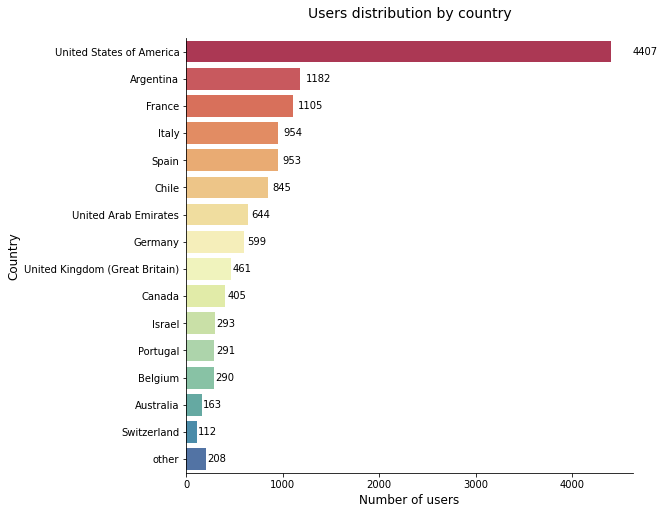

In [15]:
plt.figure(figsize = (8, 8))
ax = sns.barplot(data = countries, y = 'country', x = 'uid', palette = "Spectral")
for p in ax.patches:
        width = p.get_width()
        plt.text(1.05*p.get_width(), p.get_y()+0.5*p.get_height(),
                 '%d' % int(width),
                 ha='left', va='center')
plt.xlabel("Number of users", size=12)
plt.ylabel("Country", size=12)
plt.title('Users distribution by country', pad = 20, size = 14)
sns.despine()

In [16]:
countries.uid.describe()

count      16.000000
mean      807.000000
std      1021.086154
min       112.000000
25%       290.750000
50%       530.000000
75%       953.250000
max      4407.000000
Name: uid, dtype: float64

#### Анализ аудитории по возрасту
- Смотрим на описательную статистику возраста среди пользователей
- Строим график распределения количества пользователей по количеству лет

In [17]:
users_info.age.describe()

count    12912.000000
mean        32.010378
std         10.224415
min         16.000000
25%         25.000000
50%         30.000000
75%         38.000000
max         99.000000
Name: age, dtype: float64

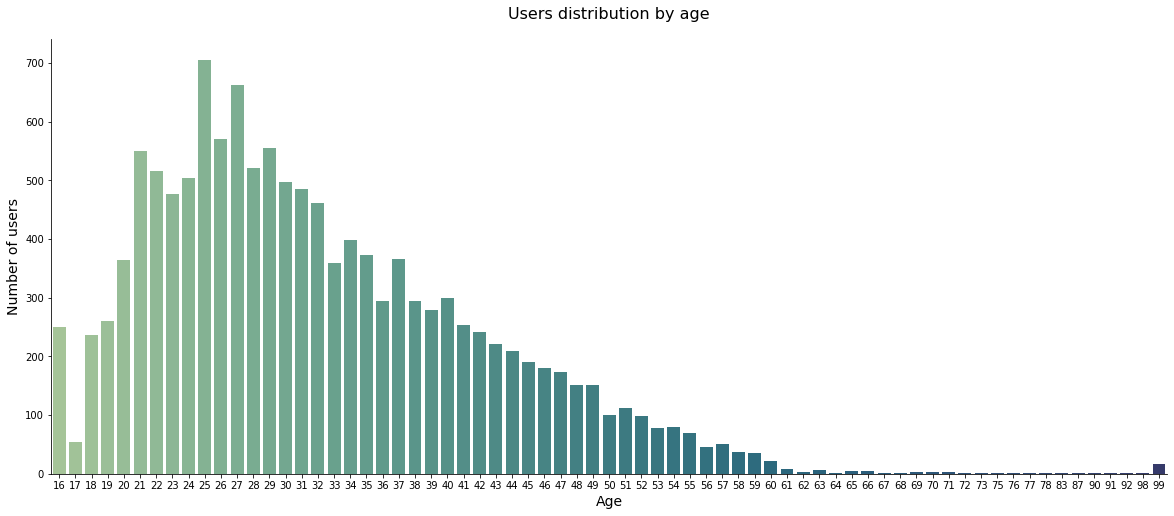

In [18]:
plt.figure(figsize = (20, 8))
ax = sns.countplot(data = users_info, x = 'age',  palette = "crest")
plt.xlabel("Age", size=14)
plt.ylabel("Number of users", size=14)
plt.title('Users distribution by age', pad = 20, size = 16)
sns.despine()

In [19]:
users_info.age.describe()

count    12912.000000
mean        32.010378
std         10.224415
min         16.000000
25%         25.000000
50%         30.000000
75%         38.000000
max         99.000000
Name: age, dtype: float64

#### Анализ аудитории по количеству посещений
- Создаем колонку, содержащую количество посещений приложения пользователем
- Строим график распределения количества пользователей по частоте посещения приложения

In [20]:
users_info['visit_days'] = users_info['visit_days'].fillna(0)

In [21]:
users_info['visits'] = users_info['visit_days'].apply(lambda x: len(str(x).split(',')) if x != 0 else 0)

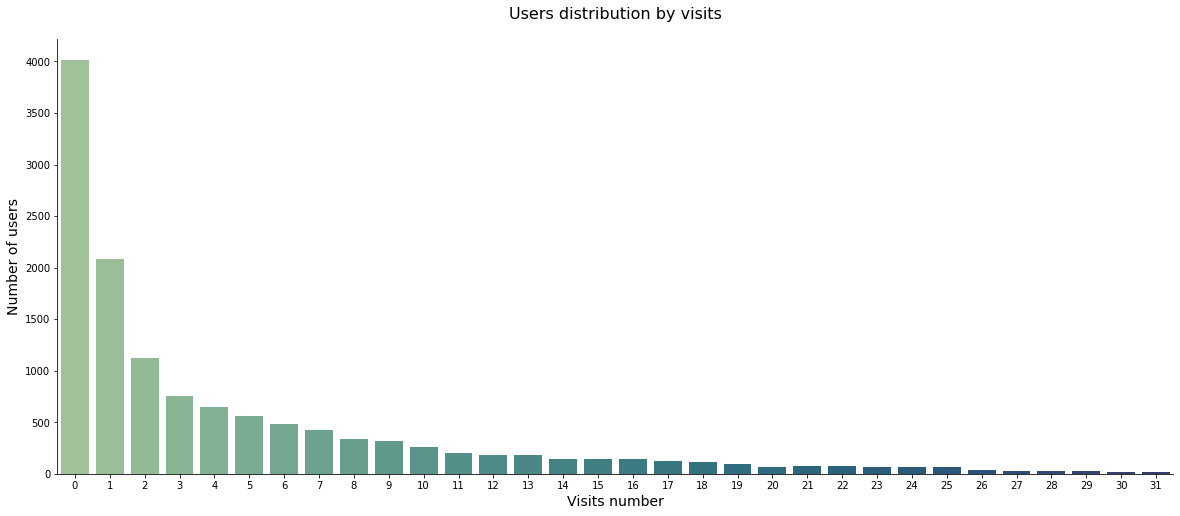

In [22]:
plt.figure(figsize = (20, 8))
ax = sns.countplot(data = users_info, x = 'visits', palette = "crest")
plt.xlabel("Visits number", size=14)
plt.ylabel("Number of users", size=14)
plt.title('Users distribution by visits', pad = 20, size = 16)
sns.despine()

In [23]:
users_info.visits.describe()

count    12912.00000
mean         4.55855
std          6.22509
min          0.00000
25%          0.00000
50%          2.00000
75%          7.00000
max         31.00000
Name: visits, dtype: float64

#### Анализ соотношения полов
После небольшого ресерча и статьи (https://habr.com/ru/company/vdsina/blog/490238/) о соотношении мужчин и женщин в дейтинговых приложениях, предполагаем, что обозначение пола следующее: male = 1, female = 0

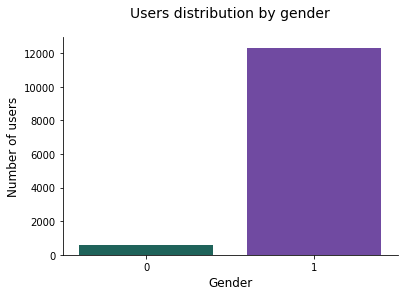

In [24]:
sns.countplot(data = users_info, x = 'gender', palette = ['#136f62' , '#6e3bb0'])
plt.xlabel("Gender", size=12)
plt.ylabel("Number of users", size=12)
plt.title('Users distribution by gender', pad = 20, size = 14)
sns.despine()

#### Conversion window - количество недель от момента регистации до целевого действия  - оплаты подписки
- Создаем столбец, который будет содержать информацию о разнице между регистрацией пользователя и датой оплаты какого-либо продукта
- Строим графики распределения для сроков первой оплаты подписки в приложении

In [25]:
for data in [transactions_test, transactions_control_1, transactions_control_2]:
    data['weeks_until_payment'] = (data.paid_at - data.joined_at)
    data['weeks_until_payment'] = round(data['weeks_until_payment'].dt.days / 7)
    data['weeks_until_payment'] = data['weeks_until_payment'].fillna(0).astype('int')

In [26]:
# Для лучшего восприятия графиков зададим цвет для тестовой и контрольной группы
group_colors = dict(test = '#05b655',cont = '#1b9cae')
group_palette = ['#1bb9ec','#05b655']

График для тестовой группы

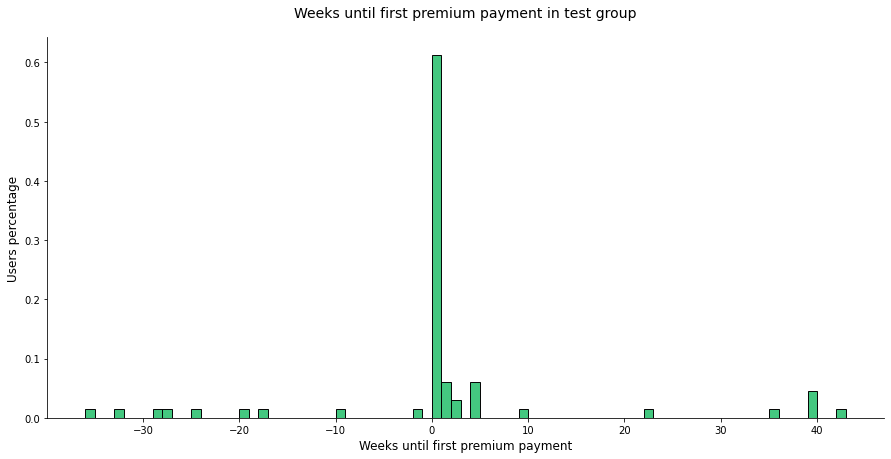

In [27]:
plt.figure(figsize = (15, 7))
sns.histplot(data = transactions_test \
             .query("product_type == ['premium', 'premium_no_trial']")
             .sort_values(['uid', 'paid_at']) \
             .drop_duplicates('uid'), \
             
             x = 'weeks_until_payment', \
             stat = 'probability', \
             binwidth = 1, \
             color = group_colors['test'])
plt.xlabel("Weeks until first premium payment", size=12)
plt.ylabel("Users percentage", size=12)
plt.title('Weeks until first premium payment in test group', pad = 20, size = 14)
sns.despine()

График для контрольной группы

In [28]:
transactions_control = pd.concat([transactions_control_1, transactions_control_2])

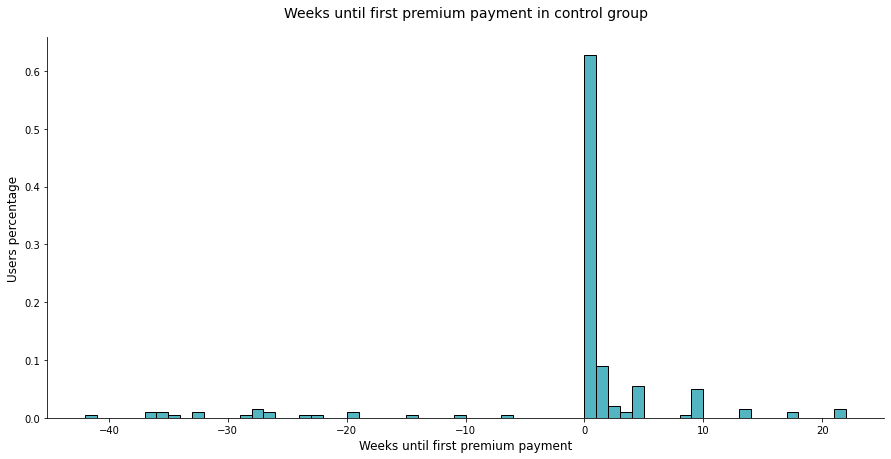

In [29]:
plt.figure(figsize = (15, 7))
sns.histplot(data = transactions_control \
             .query("product_type == ['premium', 'premium_no_trial']")
             .sort_values(['uid', 'paid_at']) \
             .drop_duplicates('uid'), \
             x = 'weeks_until_payment', \
             stat = 'probability', \
             binwidth = 1, \
             color = group_colors['cont'] )
plt.xlabel("Weeks until first premium payment", size=12)
plt.ylabel("Users percentage", size=12)
plt.title('Weeks until first premium payment in control group', pad = 20, size = 14)
sns.despine()

1. Возможно, люди, у которых оплата подписки произошла раньше регистрации, получили подписку в подарок или участвовали в промоакции.  
2. Большинство пользователей в обоих группах

### ARPPU и поиск ошибок в данных 

- Объединеним датасеты по транзакциям и информации о пользователях.
- Добавим в новый датафрейм столбец с названием группы (тестовая или контрольная)

In [30]:
k = 0
group_names = ['test', 'control_1', 'control_2']
transactions_data = pd.DataFrame()
for users, transactions in zip((users_test, users_control_1, users_control_2), \
                               (transactions_test, transactions_control_1, transactions_control_2)):
    users['group'] = group_names[k]
    transactions_data = pd.concat( [transactions_data, \
                       transactions.merge(users[['uid', 'age', 'gender', 'was_premium', 'is_premium', 'total_revenue', 'group', 'coins']], \
                                          on = 'uid', how = 'left')]).reset_index(drop = True)
    k += 1

Убедимся, что total_revenue равен агреггированному доходу с пользователя по столбцу revenue:
- Агрегация по revenue
- Агрегация по total_revenue

In [31]:
transactions_data.groupby(['group', 'uid'], as_index = False).agg({'revenue': 'sum'}) \
                .groupby('group', as_index = False).agg({'revenue': 'median'})

,group,revenue
0,control_1,9490.0
1,control_2,7969.0
2,test,12727.0


In [32]:
transactions_data.sort_values(['paid_at'], ascending = False) \
        .drop_duplicates('uid').groupby('group', as_index = False).agg({'total_revenue': 'median'}) 

,group,total_revenue
0,control_1,9139
1,control_2,7969
2,test,12727


In [33]:
transactions_data.query('group == "control_1"').groupby('uid', as_index = False) \
                    .agg({'revenue': 'sum', 'total_revenue': 'max'}) \
                    .query('total_revenue != revenue')

,uid,revenue,total_revenue
181,892355163.0,30264.0,0
192,960936960.0,806.0,26


In [34]:
transactions_data.query('uid == 960936960.0')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,weeks_until_payment,age,gender,was_premium,is_premium,total_revenue,group,coins
338,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type,99,30,1,1.0,1.0,26,control_1,99958.0
374,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type,99,30,1,1.0,1.0,26,control_1,99958.0
497,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type,99,30,1,1.0,1.0,26,control_1,99958.0


In [35]:
transactions_data.query('from_page == ["refund_VP", "refung_AP", "refund_WP"]')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,weeks_until_payment,age,gender,was_premium,is_premium,total_revenue,group,coins
338,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type,99,30,1,1.0,1.0,26,control_1,99958.0
374,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type,99,30,1,1.0,1.0,26,control_1,99958.0
497,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type,99,30,1,1.0,1.0,26,control_1,99958.0


In [36]:
transactions_data = transactions_data \
                    .drop(transactions_data.query('from_page == ["refund_VP", "refung_AP", "refund_WP"]') \
                    .index)

Во втором случае скорее всего произошла ошибка при записи данных, поэтому просто заменяем значение по столбцу total_revenue для пользователя

In [37]:
transactions_data.query('uid == 892355163.0')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,weeks_until_payment,age,gender,was_premium,is_premium,total_revenue,group,coins
576,892355163.0,United States of America,2017-10-15 18:45:00,2017-10-16 09:52:00,30264.0,68.0,super_popup,other_type,0,40,1,1.0,0.0,0,control_1,0.0


In [38]:
transactions_data.loc[transactions_data['uid'] == 892355163.0, 'total_revenue'] = 30264.0

Чтобы понимать, какую роль может играть страница, с которой пользователь перешел для оплаты, сделаем преобразование таблицы с транзакциями.  
По всем типам страницы, кроме none и fans наблюдается следующая картина: пользователи либо платили за премиум подписку (или ее пробную версию), либо тип продукта other_type и coins.   
Используем это при дальнейшем анализе.


Страницы, переход с которых закончился оплатой trial_premium или premium_no_trial

In [39]:
transactions_data.groupby(['product_type', 'from_page'], as_index = False) \
                .agg({'uid': 'count'}) \
                .pivot(index = 'from_page', columns = 'product_type', values = 'uid') \
                .fillna(0) \
                .query('premium_no_trial > 0 or trial_premium > 0')

product_type,coins,other_type,premium_no_trial,trial_premium
from_page,,,,
autoreply_message,0.0,0.0,67.0,13.0
dating,0.0,0.0,18.0,6.0
delivery_vip,0.0,0.0,1.0,0.0
fans,5.0,6.0,4.0,0.0
left_sidebar_menu,0.0,0.0,45.0,2.0
no_sympathy,0.0,0.0,2.0,0.0
none,39.0,5.0,53.0,3.0
popular_users_block,0.0,0.0,18.0,1.0
popular_users_chat,0.0,0.0,13.0,2.0


Страницы, переход с которых закончился оплатой coins или other type

In [40]:
transactions_data.groupby(['product_type', 'from_page'], as_index = False) \
                .agg({'uid': 'count'}) \
                .pivot(index = 'from_page', columns = 'product_type', values = 'uid') \
                .fillna(0) \
                .query('coins > 0 or other_type > 0')

product_type,coins,other_type,premium_no_trial,trial_premium
from_page,,,,
ad_to_photo,7.0,3.0,0.0,0.0
admins,0.0,2.0,0.0,0.0
autorefill,48.0,0.0,0.0,0.0
coins_popup,0.0,3.0,0.0,0.0
empty_admins,0.0,5.0,0.0,0.0
empty_likes,212.0,60.0,0.0,0.0
empty_mutual,0.0,2.0,0.0,0.0
fans,5.0,6.0,4.0,0.0
gifts,16.0,4.0,0.0,0.0


### Распределение дохода с пользователя в разных группах
1. Создаем датасет с информацией о доходе с пользователей, которые совершили покупки
3. Строим графики и смотрим на описательную статистику
4. Разбираемся в выбросах

In [41]:
revenue_per_user = transactions_data.drop_duplicates('uid') \
                    .drop(columns = ['paid_at', 'payment_id', 'from_page', 'product_type'])

In [42]:
revenue_per_user.head(3)

,uid,country,joined_at,revenue,weeks_until_payment,age,gender,was_premium,is_premium,total_revenue,group,coins
0,891345942.0,Italy,2017-05-11 13:00:00,12909.0,27,52,1,1.0,1.0,12909.0,test,0.0
1,892054251.0,United States of America,2017-10-22 00:33:00,13923.0,1,37,1,1.0,1.0,13923.0,test,0.0
2,892236423.0,United States of America,2017-10-18 01:09:00,3783.0,1,23,1,1.0,1.0,95823.0,test,378.0


### ARPU

Распределение дохода с пользователя в **тестовой группе**

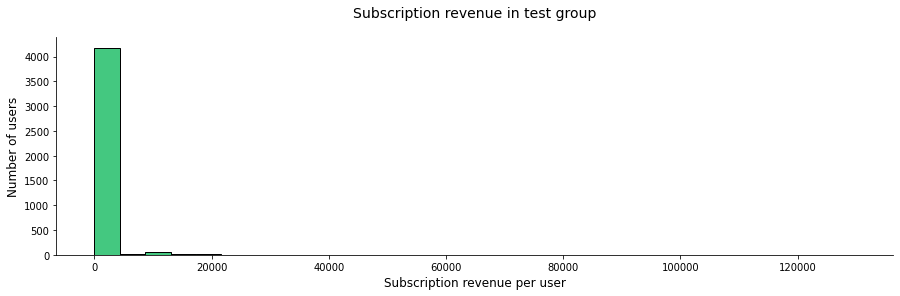

In [43]:
plt.figure(figsize = (15, 4))
sns.histplot(data = users_info.query("group == 'test'"),
             x = 'total_revenue',
             color = group_colors['test'],
             bins = 30)
plt.xlabel("Subscription revenue per user", size=12)
plt.ylabel("Number of users", size=12)
plt.title('Subscription revenue in test group', pad = 20, size = 14)
sns.despine()

Распределение дохода с пользователя в **контрольной группе**

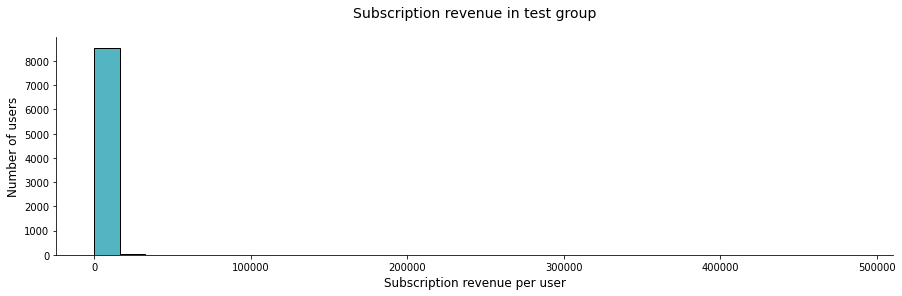

In [44]:
plt.figure(figsize = (15, 4))
sns.histplot(data = users_info.query("group == ['control_1', 'control_2']"),
             x = 'total_revenue',
             color = group_colors['cont'],
             bins = 30)
plt.xlabel("Subscription revenue per user", size=12)
plt.ylabel("Number of users", size=12)
plt.title('Subscription revenue in test group', pad = 20, size = 14)
sns.despine()

Значения ARPU в тестовой и контрольной группах

In [45]:
ARPU = pd.DataFrame( 
{'group' : ['control', 'test'],
'revenue' : [users_info \
           .query("group != 'test'") \
           .agg({'total_revenue': 'mean'})[0],

            users_info\
            .query("group == 'test'")\
            .agg({'total_revenue': 'mean'})[0]]}, 
            index = None)
ARPU

,group,revenue
0,control,523.210716
1,test,534.080316


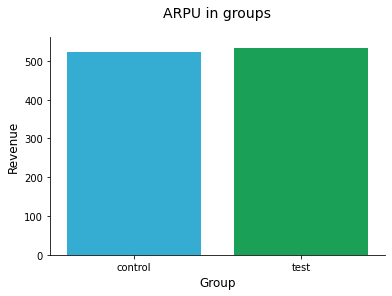

In [46]:
sns.barplot(data = ARPU, x = 'group', y = 'revenue', palette = group_palette)
plt.xlabel("Group", size=12)
plt.ylabel("Revenue", size=12)
plt.title('ARPU in groups', pad = 20, size = 14)
sns.despine()

### ARPPU

Распределение дохода с платящего пользователя в **тестовой группе**

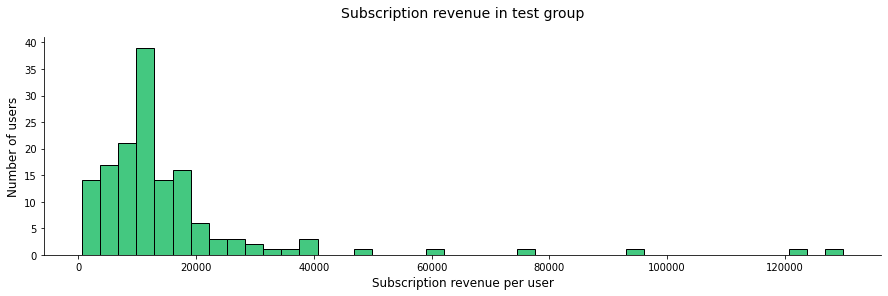

In [47]:
plt.figure(figsize = (15, 4))
sns.histplot(data = revenue_per_user.query("group == 'test'"),\
             x = 'total_revenue', \
             color = group_colors['test'])
plt.xlabel("Subscription revenue per user", size=12)
plt.ylabel("Number of users", size=12)
plt.title('Subscription revenue in test group', pad = 20, size = 14)
sns.despine()

Распределение дохода с платящего пользователя в **контрольной группе**

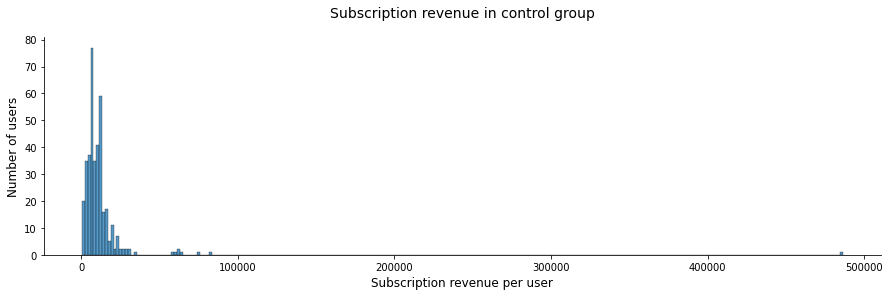

In [48]:
plt.figure(figsize = (15, 4))
sns.histplot(data = revenue_per_user.query("group == ('control_1', 'control_2')"),
             x = 'total_revenue')
plt.xlabel("Subscription revenue per user", size=12)
plt.ylabel("Number of users", size=12)
plt.title('Subscription revenue in control group', pad = 20, size = 14)
sns.despine()

In [49]:
ARPPU = pd.DataFrame( 
{'group' : ['control', 'test'],
'revenue' : [revenue_per_user \
           .query("group != 'test'") \
           .agg({'total_revenue': 'mean'})[0],

            revenue_per_user\
            .query("group == 'test'")\
            .agg({'total_revenue': 'mean'})[0]]}, 
            index = None)
ARPPU

,group,revenue
0,control,11957.633245
1,test,15759.027397


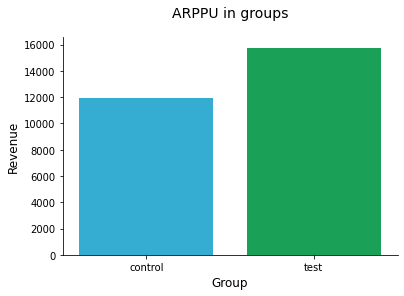

In [50]:
sns.barplot(data = ARPPU, x = 'group', y = 'revenue', palette = group_palette)
plt.xlabel("Group", size=12)
plt.ylabel("Revenue", size=12)
plt.title('ARPPU in groups', pad = 20, size = 14)
sns.despine()

### Дубликаты и выбросы

Необходимо понять природу сильных выбросов (в особенности в контрольной группе) для предупреждения ошибок при проведении статистического анализа.

- Смотрим на записи в группе control_1, которые привели к наличию сильных выбросов
- Убеждаемся, что на наличие 'этих выбросов повлиял один уникальный пользователь

In [51]:
transactions_data[transactions_data.total_revenue > 400000].sort_values('paid_at').head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,weeks_until_payment,age,gender,was_premium,is_premium,total_revenue,group,coins
322,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:42:00,3783.0,67.0,menu,other_type,0,22,1,1.0,1.0,486330.0,control_1,3608.0
286,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type,0,22,1,1.0,1.0,486330.0,control_1,3608.0
320,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type,0,22,1,1.0,1.0,486330.0,control_1,3608.0
442,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type,0,22,1,1.0,1.0,486330.0,control_1,3608.0
301,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:57:00,3783.0,67.0,empty_admins,other_type,0,22,1,1.0,1.0,486330.0,control_1,3608.0


In [52]:
transactions_data[transactions_data.total_revenue > 400000].uid.nunique()

1

- Посмотрим, есть ли дубликаты, которые могли возникнуть по ошибке при записи данных.  
- Ищем записи, которые совпадают по параметрам **paid_at, revenue, payment_id, from_page, product_type,** поскольку это будет свидетельствовать о возможной ошибке при записи в данных.  
- Видим, что даже для этого пользователя такие записи есть ( только 19 строк из 27, приходящиеся на данного пользователя, уникальные).   
- Имеет смысл пройтись по всему набору данных и удалить подобные дубликаты.

In [53]:
transactions_data.query('uid == 892333905.0') \
                .groupby(['paid_at', 'revenue', 'payment_id','from_page','product_type']) \
                .agg({'uid': 'count'}).shape[0]

19

In [54]:
transactions_data[transactions_data.total_revenue > 400000].shape[0]

27

In [55]:
transactions_data = transactions_data.drop_duplicates(['uid', 'paid_at', 'revenue', 'from_page', 'payment_id', 'product_type'])

- После удаления дубликатов создаем датасет **bags_revenue**, в котором будут записи о все пользователях, значение агрегированного revenue для которых не совпадает с total_revenue.  
- Проходимся по этому датасету и для всех попавших в него uid меняем значение total_revenue в датасете transactions_data.

In [56]:
bags_revenue = transactions_data.groupby('uid', as_index = False) \
                    .agg({'revenue': 'sum', 'total_revenue': 'max', 'group': 'max'}) \
                    .query('total_revenue != revenue')
bags_revenue.head()

,uid,revenue,total_revenue,group
47,891252072.0,7553.0,8814.0,control_1
89,891320916.0,10075.0,13858.0,control_1
110,891365490.0,8814.0,10075.0,control_1
114,891367521.0,16081.0,20462.0,control_1
137,891452706.0,12597.0,18902.0,control_1


In [57]:
for uid in bags_revenue['uid']:
    transactions_data.loc[transactions_data['uid'] == uid, 'total_revenue'] = \
    float(bags_revenue[bags_revenue.uid == uid]['revenue'])
revenue_per_user = transactions_data.drop_duplicates('uid')

Учитываем, что проблема может быть не только в наличии дубликатов, посмотрим в какие даты пользователь uid = 892333905.0 совершал покупки.  
Видим, что 15 раз пользователь оплачивал покупки 16.10.2017 - в день своей регистрации в приложении.

In [58]:
transactions_data[transactions_data.total_revenue > 400000].paid_at.dt.date.value_counts()

2017-10-16    15
2017-10-17     4
Name: paid_at, dtype: int64

**Причины для удаления записей о пользователе:**
 - Человек проявлял подозрительную активность только в первые 2 суток регистрации
 - Он является единственным пользователем, который стал причиной экстремально сильных выбросов не только среди пользователей первой контрольной группы, но и всех пользователей в целом
 - По результатам графиков в разделе анализа аудитории видим, что из Италии около 1000 пользователей, но такое поведение ни у кого больше не наблюдается
 - Не совсем понятно, что послужило причиной такому поведению
 - Пользователь расплачивался преимущественно внутренней валютой
 - Нельзя сделать вывод, какие записи о пользователе можно оставить (человек мог просто тестировать все возможностит взаимодействия в приложении за внутреннюю валюту)
 
 Удаляем записи и строим новый график распределения для контрольной группы 2

In [59]:
transactions_data = transactions_data.query('uid != 892333905.0')
users_info = users_info.query('uid != 892333905.0')

In [60]:
# Обновим датасет revenue_per_user, он зависел от transactions_data
revenue_per_user = transactions_data.drop_duplicates('uid')

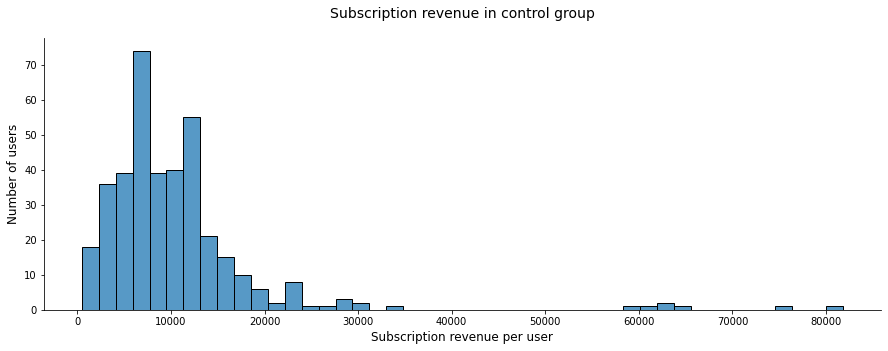

In [61]:
plt.figure(figsize = (15, 5))
sns.histplot(data = revenue_per_user.query("group == ('control_1', 'control_2')"),
             x = 'total_revenue')
plt.xlabel("Subscription revenue per user", size=12)
plt.ylabel("Number of users", size=12)
plt.title('Subscription revenue in control group', pad = 20, size = 14)
sns.despine()

**Проанализируем выбросы total revenue в тестовой группе**
 - Посмотрим на записи о покупках, которые возможно стали причиной таких больших значений по полю total_revenue
 - По полю product_type	видим, что пользователи оформляли премиум подписку и заплатили одинаковую сумму
 - Даты оплаты разные, оставляем записи об этих пользователях, поскольку ничего подозрительного в записях не обнаружено

In [62]:
transactions_data.query('group == "test"') \
                [transactions_data.total_revenue > 120000] \
                .sort_values('revenue', ascending = False) \
                .drop_duplicates('uid')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,weeks_until_payment,age,gender,was_premium,is_premium,total_revenue,group,coins
12,891178380.0,Spain,2017-08-11 03:54:00,2017-09-11 21:53:00,113477.0,147.0,promo_09,premium_no_trial,4,42,1,1.0,1.0,129870.0,test,85.0
196,892038759.0,United Arab Emirates,2017-10-22 11:12:00,2017-10-22 16:23:00,113477.0,147.0,autoreply_message,premium_no_trial,0,26,1,1.0,1.0,123565.0,test,3.0


- Похожие записи обнаруживаем во второй контрольной группе  

In [63]:
transactions_data.query('group == "control_2"') \
                [transactions_data.total_revenue > 70000] \
                .sort_values(['uid','revenue'], ascending = False) \
                .drop_duplicates('uid')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,weeks_until_payment,age,gender,was_premium,is_premium,total_revenue,group,coins
672,892307238.0,Spain,2017-10-16 16:01:00,2017-10-16 20:41:00,63037.0,147.0,left_sidebar_menu,premium_no_trial,0,29,1,1.0,1.0,75647.0,control_2,43.0
697,891778551.0,United Arab Emirates,2017-10-27 21:26:00,2017-10-27 22:30:00,81796.0,147.0,left_sidebar_menu,premium_no_trial,0,30,1,1.0,1.0,81796.0,control_2,0.0


Почему доход от некоторых пользователей по премиум подписке настолько сильно отличается, утверждать нельзя.
Если в приложении есть опция оплаты за год пользования, пользователи могли ею воспользоваться.

## A/A тест
Чтобы проверить качество системы сплитования трафика и убедиться, что статистически значимые различия не будут возникать из-за технических проблем, проведем А/А тесты на метриках **ARPU и conversion rate**

1. Функция A/A теста по метрике ARPU  

Проверка гипотезы - ttest  
**H0 для t-теста, реализуемого в функции** - средние в выборках не имеют статистически значимых различий 

In [64]:
from tqdm.auto import tqdm
def aa_test_revenue(data, column, n_perc, sim):
    n1 = int(n_perc * data[data.group == 'control_1'].shape[0])
    n2 = int(n_perc * data[data.group == 'control_2'].shape[0])
    res_rev = []
    for s in tqdm(range(sim)):
        sample1 = data[data.group == 'control_1'][column].sample(n1, replace = False).values
        sample2 = data[data.group == 'control_2'][column].sample(n2, replace = False).values
        res_rev.append(stats.ttest_ind(sample1, sample2, equal_var = False)[1])
    
    plt.hist(res_rev, bins = 50)
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title("Histogram of A/A ttest simulations for ARPU")
    plt.show()
    
    print(f'FPR(p < 0.05) = {sum(np.array(res_rev) <0.05) / sim}','\n'
          f'FPR(p < 0.1) = {sum(np.array(res_rev) <0.1) / sim}')
    

2. Функция для А/А теста по метрике conversion rate

Проверка гипотезы - критерий хи-квадрат  
**H0 для критерия Хи-квадрат, реализуемого в функции** - средние в выборках не имеют статистически значимых различий 

In [65]:
def aa_test_conversion(data, n_perc, sim):
    n1 = int(n_perc * data[data.group == 'control_1'].shape[0])
    n2 = int(n_perc * data[data.group == 'control_2'].shape[0])
    res_convers = []
    
    for s in tqdm(range(sim)):

        sample_1 = data[data.group == 'control_1'] \
                .sample(n1, replace = False) \
                .groupby('is_premium', as_index = False) \
                .agg({'uid': 'count'}) \
                .rename(columns = {'uid': 'sample_1'})
        
        sample_2 = data[data.group == 'control_2'] \
                .sample(n2, replace = False) \
                .groupby('is_premium', as_index = False) \
                .agg({'uid': 'count'}) \
                .rename(columns = {'uid': 'sample_2'})     
        
        cross_tab = sample_1.merge(sample_2, on = 'is_premium').drop('is_premium', axis = 1)
        res_convers.append(stats.chi2_contingency(cross_tab)[1])
    
    plt.hist(res_convers, bins = 50)
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title(f"Histogram of A/A ttest simulations for conversion")
    plt.show()
    
    print(f'FPR(p < 0.05) = {sum(np.array(res_convers) <0.05) / sim}','\n'
          f'FPR(p < 0.1) = {sum(np.array(res_convers) <0.1) / sim}')

Применяем функции, проводим А/А тест

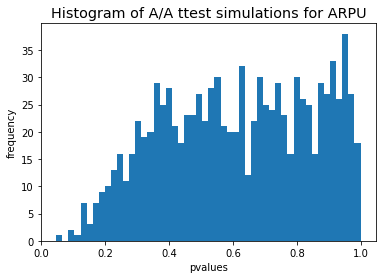

FPR(p < 0.05) = 0.001 
FPR(p < 0.1) = 0.002


In [66]:
aa_test_revenue(users_info, 'total_revenue', 0.8, 1000)

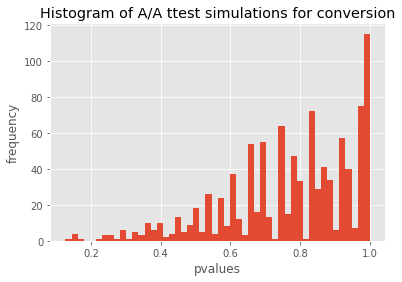

FPR(p < 0.05) = 0.0 
FPR(p < 0.1) = 0.0


In [67]:
aa_test_conversion(users_info, 0.8, 1000)

**Вывод:**  
Система сплитования не сломана и можно проводить А/В тест.

## Статистический анализ A/B теста

Поскольку был проведен А/В тест, в котором для новых пользователей из нескольких стран была изменена стоимость премиум-подписки, проверим:
1. Есть ли значимые различия в метрике ARPU
2. Есть ли значимые различия в метрике APRU по оплате подписки или дохода с иных категорий 
2. Есть ли значимые различия в частоте продления подписок одним пользователем
3. Есть ли значимые различия в конверсии в подписку
4. Влияет ли на наличие подписки то, была ли у пользователя премиум-подписка ранее
5. Есть ли различия в доходе между какими-либо группами пользователей

Предобработка
1. Обновим колонку total_revenue в датасете с информацией о пользователях
2. Объединим обе контрольные группы

In [68]:
users_info = users_info.drop('total_revenue', axis = 1) \
            .merge(revenue_per_user[['uid', 'total_revenue']], on = 'uid', how = 'left') \
            .fillna(0)

In [69]:
users_info['group'] = users_info['group'].apply(lambda x: 'test' if x == 'test' else 'control')

In [70]:
transactions_data['group'] = transactions_data['group'].apply(lambda x: 'test' if x == 'test' else 'control')

### ARPU

ARPU после удаления дубликатов

In [71]:
users_info.groupby('group', as_index = False) \
        .agg({'total_revenue': 'mean'})

,group,total_revenue
0,control,464.825177
1,test,541.370938


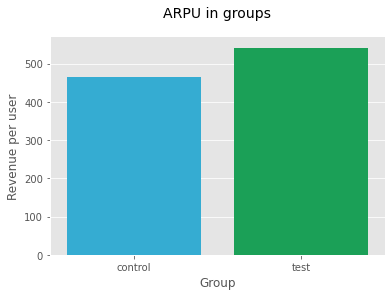

In [72]:
sns.barplot(data = users_info \
            .groupby('group', as_index = False) \
            .agg({'total_revenue': 'mean'}), \
            x = 'group', y = 'total_revenue', palette = group_palette)
plt.xlabel("Group", size=12)
plt.ylabel("Revenue per user", size=12)
plt.title('ARPU in groups', pad = 20, size = 14)
sns.despine()

ARPPU в группах

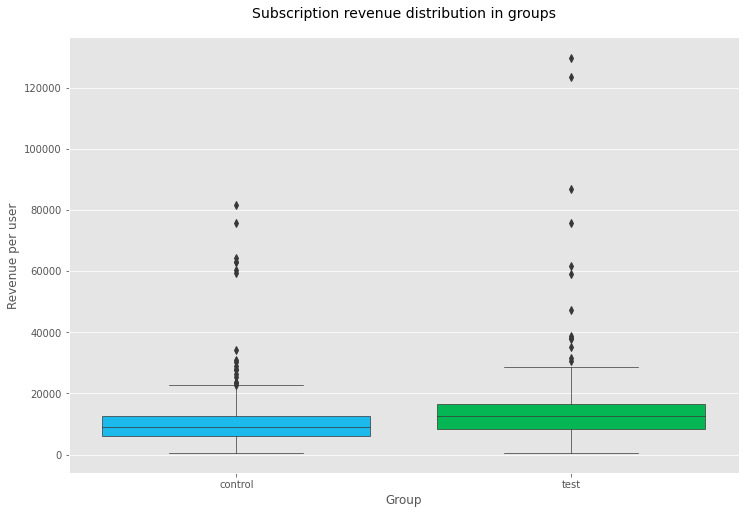

In [73]:
plt.figure(figsize= (12, 8))
sns.boxplot(x = 'group', \
            y = 'total_revenue', \
            data = users_info.query('total_revenue > 0').sort_values('group'), \
            palette = group_palette, \
            saturation = 1,\
            linewidth = 0.7)

plt.xlabel("Group", size=12)
plt.ylabel("Revenue per user", size=12)
plt.title('Subscription revenue distribution in groups', pad = 20, size = 14)
sns.despine()

### 1. Проверка равенства ARPU в тестовой и контрольной группах

Проверка выборок на нормальность.  
**H0** - выборка взята из генеральной совокупности, в которой значения распределены нормально  
**Результат** - распределения в выборках значимо отличаются от нормального.

In [74]:
print('test p-value:', '\t', stats.shapiro(users_info.query("group == 'test'")['total_revenue'])[1], '\n'
     'control p-value:', '\t', stats.shapiro(users_info.query("group == 'control'")['total_revenue'])[1])

test p-value: 	 0.0 
control p-value: 	 0.0


/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Проверим выборки на гомогенность дисперсии  
**H0** - выборки взяты из генеральных совокупностей с одинаковыми дисперсиями  
**Результат** - дисперсии в группах не имеют значимых различий

In [75]:
stats.levene(users_info.query("group == 'test'")['total_revenue'], \
             users_info.query("group == 'control'")['total_revenue'])

LeveneResult(statistic=1.365013978151313, pvalue=0.2426919780329993)

Проверяем гипотезу о равенстве средних в двух выборках при помощи t-теста

**H0** - нет значимых различий между выборочными средними  
**Результат** - средние в выборках стат значимо не различаются

In [76]:
stats.ttest_ind(users_info[users_info.group == 'test']['total_revenue'], \
              users_info[users_info.group == 'control']['total_revenue'])

Ttest_indResult(statistic=1.1683381266359978, pvalue=0.2426919780346818)

Дополнительно используем бутстреп-анализ на наших данных, т.к распределение в выборках значимо отличается от нормального.

Создаем функцию для бутстреп-анализа **bootstrap**

**H0, проверяемая в функции** - нет значимых различий между средними в подвыборках

Проверка по графику распределения разницы средних - если в доверительный интервал входит 0, H0 принимается  


In [78]:
def bootstrap(data, dv, 
              per = 0.9, 
              boot_it = 1000, 
              conf_level = 0.95 ):
    
    boot_len = int(per * max([len(data.query("group == 'test'")[dv]), \
                              len(data.query("group == 'control'")[dv])]))
    boot_data = []
    
    for i in tqdm(range(boot_it)): 
        samples_1 = data.query("group == 'test'")[dv] \
                    .sample( boot_len, replace = True) \
                    .values
        samples_2 = data.query("group == 'control'")[dv] \
            .sample( boot_len, replace = True) \
            .values
        boot_data.append(np.mean(samples_1-samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - conf_level)/2
    right_quant = 1 - (1 - conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
      
        
    plt.hist(pd_boot_data[0], bins = 50)
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0, ymax=70, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    
    print(f'p-value = {p_value}')

Применяем функцию на группах  
**Результат** - между тестовой и контрольной группой нет значимых различий по метрике total revenue

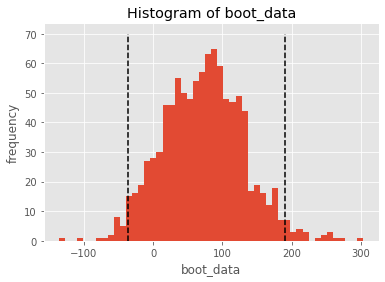

p-value = 0.2130280757859132


In [79]:
bootstrap(users_info, 'total_revenue')

**Избавимся от выбросов и посмотрим на результат проверки гипотез о равенстве средних в группах**
- Берем пороговое значение по метрике revenue в 40 000 (опираемся на графики распределения дохода в группах)
- Считаем, сколько значений на метрике revenue превышает 40 000 в каждой группе
- Создаем датасет без выбросов

In [80]:
users_info.query('total_revenue > 40000') \
            .groupby('group') \
            .agg({'uid': 'count'})

,uid
group,
control,7
test,7


In [151]:
users_copy = users_info.query('total_revenue < 40000')

**H0** - средние значения значимо отличаются  
**Результат** - значимых различий в выборочных средних нет

In [82]:
stats.ttest_ind(users_copy[users_copy.group == 'test']['total_revenue'], \
              users_copy[users_copy.group  == 'control']['total_revenue'])

Ttest_indResult(statistic=-0.09822393865565465, pvalue=0.9217560007522798)

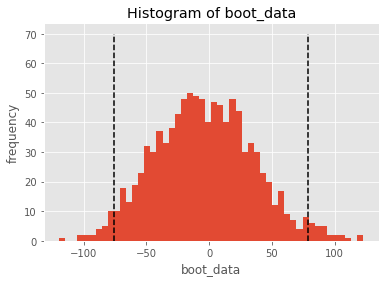

p-value = 0.9243610169839097


In [84]:
bootstrap(users_copy, 'total_revenue')

### Вывод:

t-test и бутстреп анализ не показали стат значимых различий по метрике ARPU между тестовой и контрольной группой. 

Сильные выбросы значений total revenue (суммарный доход с пользователя) влияют на величину p-value, получаемого при проверке гипотезы о равенстве средних, но их присутствие не сильно влияет на результаты эксперимента.

### 2. Критерий Хи-квадрат независимости метрики conversion rate от группы

Проверим различия в распределении количества пользователей с подпиской и без в разных группах.  
Для этого используем критерий Хи-квадрат и таблицы сопряженности.
1. Conversion rate для групп

In [85]:
CR = users_info.groupby('group') \
        .agg({'is_premium': 'mean'}) \
        .mul(100) \
        .round(2) \
        .reset_index() \
        .rename(columns = {'is_premium': 'conversion_percentage'})
CR

,group,conversion_percentage
0,control,4.44
1,test,3.64


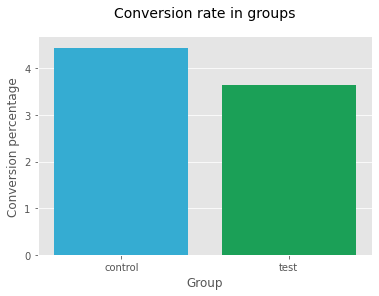

In [86]:
sns.barplot(data = CR, x = 'group', y = 'conversion_percentage', palette = group_palette)
plt.xlabel("Group", size=12)
plt.ylabel("Conversion percentage", size=12)
plt.title('Conversion rate in groups', pad = 20, size = 14)
sns.despine()

2. Таблица сопряженности

In [87]:
pd.crosstab(users_info.group, users_info.is_premium)

is_premium,0.0,1.0
group,,
control,8221,382
test,4151,157


3. Критерий Хи-квадрат независимости переменных в талице сопряженности  
**H0** - количество пользователей, оформивших и не оформивших подписку не зависит от группы, распределение равномерно.
**Результат** - отвергаем H0

In [88]:
stats.chi2_contingency(pd.crosstab(users_info.group, users_info.is_premium))

(4.34896621022394,
 0.0370314183684888,
 1,
 array([[8243.84757184,  359.15242816],
        [4128.15242816,  179.84757184]]))

### Вывод:
Конверсия в подписку зависит от группы. В контрольной группе конверсия больше, чем в тестовой.

### 3. Критерий Хи-квадрат независимости конверсии в подписку от метрики was_premium

1. Conversion rate для групп

In [89]:
CR_2 = users_info.groupby('was_premium') \
        .agg({'is_premium': 'mean'}) \
        .mul(100) \
        .round(2) \
        .reset_index() \
        .rename(columns = {'is_premium': 'conversion_percentage'})
CR_2

,was_premium,conversion_percentage
0,0.0,0.00
1,1.0,42.98


2. Критерий Хи-квадрат независимости переменных в талице сопряженности  
**H0** - количество пользователей, оформивших и не оформивших подписку не зависит от метрики was_premium (была ли у пользователя подписка ранее)

**Результат** - отвергаем H0 и для тестовой, и для контрольной группы

**Тестовая группа:**

In [90]:
test_cross= pd.crosstab(users_info.query("group == 'test'").was_premium, users_info.query("group == 'test'").is_premium)

In [91]:
stats.chi2_contingency(test_cross)

(1546.5575150564396,
 0.0,
 1,
 array([[3757.86908078,  142.13091922],
        [ 393.13091922,   14.86908078]]))

**Контрольная группа:**

In [92]:
control_cross = pd.crosstab(users_info.query("group == 'control'").was_premium, users_info.query("group == 'control'").is_premium)

In [93]:
stats.chi2_contingency(control_cross)

(3654.687604882869,
 0.0,
 1,
 array([[7412.56503545,  344.43496455],
        [ 808.43496455,   37.56503545]]))

### Вывод:
Количество пользователей, оформивших и не оформивших подписку в группах зависит от того, была ли у пользователя подписка ранее.

### 4.  Анализ ARPU от подписки

- Создаем датасет, в который входят только записи об оплате премиальной или пробной подписки
- Пересчитываем доход с пользовтеля

In [94]:
user_revenue_premium = transactions_data.query("product_type == ['premium_no_trial', 'trial_premiun']") \
                        .groupby(['uid', 'paid_at','weeks_until_payment', 'group'], as_index = False) \
                        .agg({'revenue': 'sum', 'paid_at': 'count', 'weeks_until_payment': 'min'}) \
                        .rename(columns ={'paid_at': 'payment_frequency'})
user_revenue_premium.head()

,uid,group,revenue,payment_frequency,weeks_until_payment
0,891068079.0,control,6292.0,1,9
1,891071157.0,test,9100.0,1,0
2,891077727.0,control,6292.0,1,0
3,891092322.0,control,5278.0,1,4
4,891112263.0,control,4680.0,1,9


In [95]:
premium = users_info[['uid', 'group']] \
        .merge(user_revenue_premium[['uid', 'payment_frequency','weeks_until_payment', 'revenue']], on = 'uid', how = 'left') \
        .fillna(0)
premium.head()

,uid,group,payment_frequency,weeks_until_payment,revenue
0,892309896,test,0.0,0.0,0.0
1,892044516,test,0.0,0.0,0.0
2,892185708,test,0.0,0.0,0.0
3,892130292,test,0.0,0.0,0.0
4,891406035,test,0.0,0.0,0.0


ARPU с подписки в группах

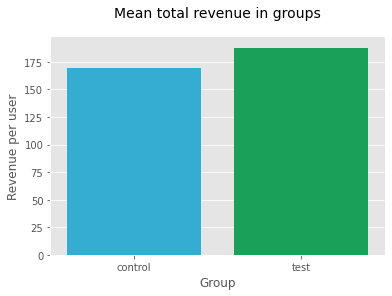

In [96]:
sns.barplot(data = premium \
            .groupby('group', as_index = False) \
            .agg({'revenue': 'mean'}), \
        
            x = 'group', y = 'revenue', palette = group_palette)

plt.xlabel("Group", size=12)
plt.ylabel("Revenue per user", size=12)
plt.title('Mean total revenue in groups', pad = 20, size = 14)
sns.despine()

Проверка выборок на нормальность.  
**H0** - выборка взята из генеральной совокупности, в которой значения распределены нормально  
**Результат** - распределения в выборках значимо отличаются от нормального.

In [97]:
print('test p-value:', '\t', stats.shapiro(premium.query("group == 'test'")['revenue'])[1], '\n'
     'control p-value:', '\t', stats.shapiro(premium.query("group =='control'")['revenue'])[1])

test p-value: 	 0.0 
control p-value: 	 0.0


/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Проверка на гомогенность дисперсии  
**H0** - выборки взяты из генеральных совокупностей с одинаковыми дисперсиями  
**Результат** - дисперсии в группах значимо не различаются 

In [98]:
stats.levene(premium.query("group == 'test'")['revenue'], \
             premium.query("group  == 'control'")['revenue'])

LeveneResult(statistic=0.20918399270011884, pvalue=0.6474154219912684)

**H0** - ни одно из средних значений в выборках не отличается от других  
**Результат** - среднее хотя бы в одной группе значимо отличается от других

In [99]:
stats.ttest_ind(premium.query("group == 'test'")['revenue'], \
             premium.query("group  == 'control'")['revenue'])

Ttest_indResult(statistic=0.4573663659476053, pvalue=0.6474154219931683)

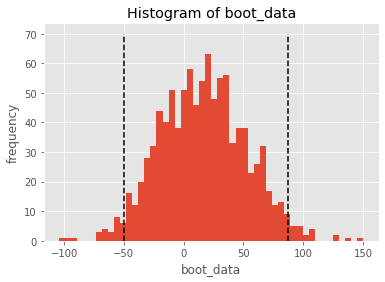

p-value = 0.6467204441396105


In [101]:
bootstrap(premium, 'revenue')

### Вывод:
Как и в случае с ARPU по всем категориям трат, доход от подписки в группах стат значимо не различается.

### Retention по подписке

1. Построим барплот распределения частоты оформления подписок одним пользователем.
2. Посмотрим на диапазон дат, за который есть данные по транзакциям.
3. Строим график динамики регистрации за весь период времени.

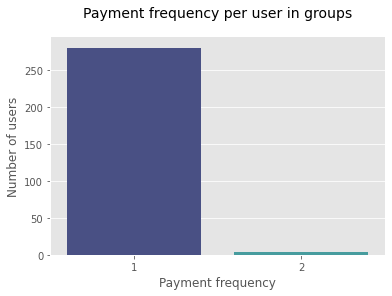

In [102]:
sns.countplot(data = user_revenue_premium, x = 'payment_frequency', palette = 'mako')
plt.xlabel("Payment frequency", size=12)
plt.ylabel("Number of users", size=12)
plt.title('Payment frequency per user in groups', pad = 20, size = 14)
sns.despine()

Данные о транзакциях представлены за период 11 месяцев с января по декабрь.   
Построим распределение количества регистраций в течение всего периода.  
Пользователеи регистрировались в течение всего года с пиками в мае и октябре. Значит, возможность повторно оформить подписку у большего количества пользователей была. Тем не менее, чаще всего пользователи оформляли подписку только 1 раз.

In [103]:
user_revenue_premium

,uid,group,revenue,payment_frequency,weeks_until_payment
0,891068079.0,control,6292.0,1,9
1,891071157.0,test,9100.0,1,0
2,891077727.0,control,6292.0,1,0
3,891092322.0,control,5278.0,1,4
4,891112263.0,control,4680.0,1,9
...,...,...,...,...,...
279,892421277.0,control,47723.0,1,0
280,892426491.0,test,12597.0,1,0
281,892434141.0,test,3614.0,1,0
282,892435536.0,control,4537.0,1,0


In [104]:
# Первая дата транзакции
transactions_data.query("product_type == ['premium_no_trial', 'trial_premiun']").paid_at.dt.date.min()

datetime.date(2017, 1, 11)

In [105]:
# Последняя дата транзакции
transactions_data.query("product_type == ['premium_no_trial', 'trial_premiun']").paid_at.dt.date.max()

datetime.date(2017, 12, 11)

In [106]:
transactions_data['joined_at'] = transactions_data['joined_at'].dt.date
registration = transactions_data \
                .groupby('joined_at').agg({'uid': 'nunique'}).reset_index()
registration['joined_at'] = registration['joined_at'].apply(lambda x: x.strftime("%d.%m"))        
registration.head()

,joined_at,uid
0,11.01,14
1,11.02,16
2,11.03,13
3,11.04,15
4,11.05,40


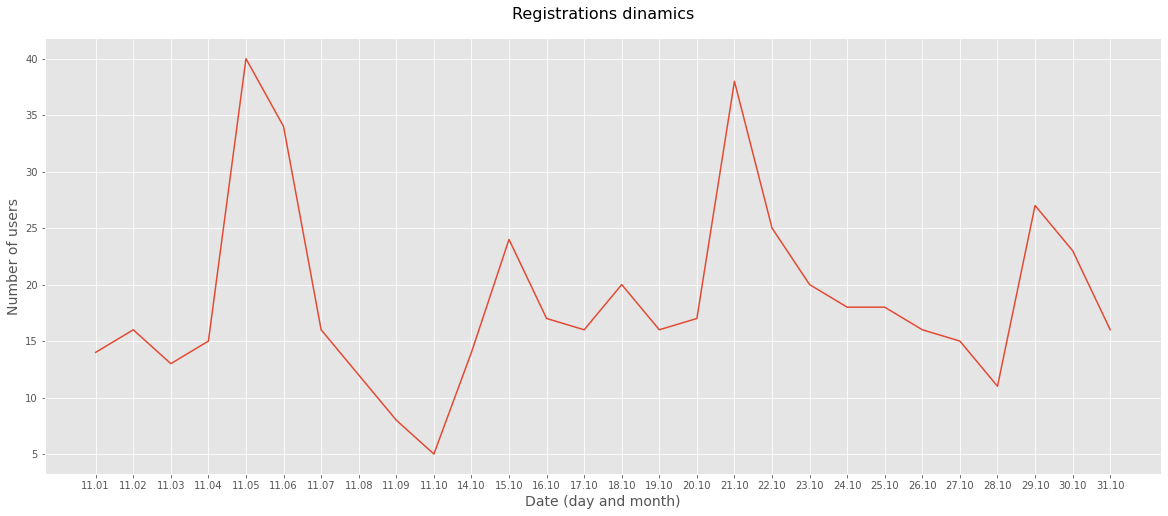

In [107]:
plt.figure(figsize = (20,8))
sns.lineplot(data = registration, x = 'joined_at', y = 'uid')
plt.xlabel("Date (day and month)", size=14)
plt.ylabel("Number of users", size=14)
plt.title('Registrations dinamics', pad = 20, size = 16)
sns.despine()

4. Проверим, имеются ли значимые различия между группами по частоте офомления подписок (payment_frequency) с помощью Хи-квадрата.  
**H0** - частота оформления подписки пользователем не зависит от группы, распределение количества пользователей равномерно.

In [108]:
pd.crosstab(user_revenue_premium.group, user_revenue_premium.payment_frequency)

payment_frequency,1,2
group,,
control,206,3
test,74,1


In [109]:
stats.chi2_contingency(pd.crosstab(user_revenue_premium.group, user_revenue_premium.payment_frequency))

(0.0,
 1.0,
 1,
 array([[206.05633803,   2.94366197],
        [ 73.94366197,   1.05633803]]))

### Вывод:
Статистически значимых рахличий между retention по подписке нет. В целом retention очень маленький и пользователи, как правило, не возвращаются за оформлением подписки.

### 5. ARPU по иным категориям трат (доход от категорий coins и other_type)

На этапе анализа транзакций мы выяснили, что пользователи переходят с разных страниц перед оплатой разных продуктов. При оплате премиальной или пробной версии подписки это одни страницы, а при оплате внутренней валютой и оплате категории other type это другой набор страниц.  
Поскольку премиум подписка предоставляет доступ к дополнительным возможностям, предполагаем, что пользование внутренней валютой и покупка продуктов из категории other type относится к этим возможностям.  
Проанализируем, есть ли различия в дополнительных тратах, совершаемых премиум-пользователями в группах.

Из всех записей по транзакциям не было и нет подписки у 31 пользователя из 524.  
Большая часть этих пользователей оплачивала продукты за внутреннюю валюту.

In [110]:
transactions_data.uid.nunique()

524

In [111]:
transactions_data.query("is_premium == 0 and was_premium == 0").uid.nunique()

31

In [112]:
transactions_data.query("is_premium == 0 and was_premium == 0").product_type.unique()

array(['coins', 'other_type'], dtype=object)

In [113]:
transactions_data.query("product_type == 'coins' and is_premium == 0 and was_premium == 0").uid.nunique()

24

In [114]:
transactions_data.query("product_type == 'other_type' and is_premium == 0 and was_premium == 0").uid.nunique()

9

Посмотрим на различия в доходе c категорий продуктов **coins, other type** среди пользователей, оформивших подписку в разных группах.
1. Создаем датасет с записями об оплате указанных продуктов пользователями, оформлявшими подписку
2. Строим график распределения дохода
2. Проводим анализ выборок

In [115]:
user_other_revenue = transactions_data.query("product_type == 'other_type' and is_premium !=0 or was_premium != 0") \
                        .groupby(['uid', 'group'], as_index = False) \
                        .agg({'revenue': 'sum', 'paid_at': 'count'}) \
                        .rename(columns ={'paid_at': 'payment_frequency'})
user_other_revenue.head()

,uid,group,revenue,payment_frequency
0,891068079.0,control,10296.0,2
1,891071157.0,test,9100.0,1
2,891075072.0,control,2327.0,1
3,891077727.0,control,6292.0,1
4,891080040.0,control,15132.0,8


In [116]:
user_other_revenue.shape

(493, 4)

In [117]:
other_revenue = users_info[['uid', 'group']] \
                .merge(user_other_revenue[['uid', 'revenue', 'payment_frequency']], on = 'uid', how = 'left') \
                .fillna(0)

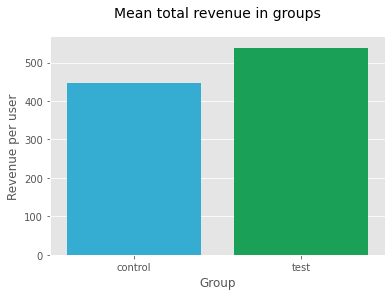

In [118]:
sns.barplot(data = other_revenue \
            .groupby('group', as_index = False) \
            .agg({'revenue': 'mean'}), \
        
            x = 'group', y = 'revenue', palette = group_palette)

plt.xlabel("Group", size=12)
plt.ylabel("Revenue per user", size=12)
plt.title('Mean total revenue in groups', pad = 20, size = 14)
sns.despine()

Проверка выборок на нормальность.  
**H0** - выборка взята из генеральной совокупности, в которой значения распределены нормально  
**Результат** - распределения в выборках значимо отличаются от нормального.

In [119]:
print('test p-value:', '\t', stats.shapiro(other_revenue.query("group == 'test'")['revenue'])[1], '\n'
     'control p-value:', '\t', stats.shapiro(other_revenue.query("group == 'control'")['revenue'])[1])


test p-value: 	 0.0 
control p-value: 	 0.0


/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Проверка на гомогенность дисперсии  
**H0** - выборки взяты из генеральных совокупностей с одинаковыми дисперсиями  
**Результат** - дисперсии в группах значимо различаются

In [120]:
stats.levene(other_revenue.query("group == 'test'")['revenue'], \
             other_revenue.query("group == 'control'")['revenue'])

LeveneResult(statistic=1.9964165229753508, pvalue=0.15769569902993813)

t-test

**H0** - ни одно из средних значений в выборках не отличается от других  
**Результат** - среднее хотя бы в одной группе значимо отличается от других

In [121]:
stats.ttest_ind(other_revenue.query("group == 'test'")['revenue'], \
             other_revenue.query("group == 'control'")['revenue'])

Ttest_indResult(statistic=1.4129460439009518, pvalue=0.15769569903101843)

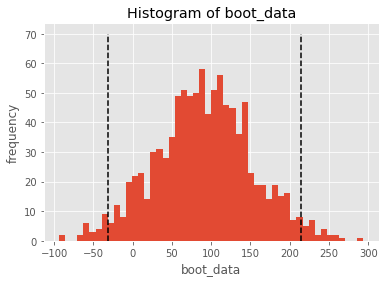

p-value = 0.13755258583010815


In [123]:
bootstrap(other_revenue, 'revenue')

Дополнительно проверим независимость распределения частоты покупки товаров от группы.  
**H0** - частота покупки товаров не зависит от группы, распределение количества пользователей равномерно.

In [124]:
pd.crosstab(user_other_revenue.group, user_other_revenue.payment_frequency)

payment_frequency,1,2,3,4,5,6,7,8,9,10,11
group,,,,,,,,,,,
control,235,50,39,13,5,4,2,1,0,3,1
test,91,24,11,5,1,4,0,1,2,0,1


In [125]:
stats.chi2_contingency(pd.crosstab(user_other_revenue.group, user_other_revenue.payment_frequency))

(11.825831576991904,
 0.29688209593591014,
 10,
 array([[233.42393509,  52.98580122,  35.80121704,  12.88843813,
           4.29614604,   5.72819473,   1.43204868,   1.43204868,
           1.43204868,   2.14807302,   1.43204868],
        [ 92.57606491,  21.01419878,  14.19878296,   5.11156187,
           1.70385396,   2.27180527,   0.56795132,   0.56795132,
           0.56795132,   0.85192698,   0.56795132]]))

### Вывод: 
ARPU по иным категориям трат не имеет значимых различий в тестовой и контрольной группе. Частота покупок от группы так же не зависит.


### 5. ANOVA по метрике ARPU

Проверим, есть ли эффект между определенными группами пользователей.
Разделим пользователей на группы по показателям:
- Возраст (разделениям по процентиллям)
- Количество посещений (разделениям по процентиллям)
- Страна


1. Создаем таблицы с диапазонами значений по возрасту, количеству посещений
2. Создаем функции, которые определяют, к какой группе пользователь относится по возрасту age_group(), количеству посещений visits_group()
2. Объединим таблицы users_info, transactions_data c полученными результатами
3. Посмотрим, есть ли разница между группами по метрике total_revenue

In [126]:
age_groups = pd.DataFrame({'age_left': users_info.age.quantile([0, 0.5, 0.75]).values.round(),\
                                'age_right': users_info.age.quantile([ 0.5, 0.75, 1]).values.round()}, \
                               index = (1,2,3))

visits_groups = pd.DataFrame({'vis_left': users_info.visits.quantile([0, 0.5, 0.75]).values.round(),\
                                'vis_right': users_info.visits.quantile([ 0.5, 0.75, 1]).values.round()}, \
                               index = (1,2,3))

In [127]:
age_groups

,age_left,age_right
1,16.0,30.0
2,30.0,38.0
3,38.0,99.0


In [128]:
visits_groups

,vis_left,vis_right
1,0.0,2.0
2,2.0,7.0
3,7.0,31.0


In [129]:
def age_group(age):
    for row in age_groups.itertuples():
        if age >= row.age_left and age < row.age_right:
            group = row.Index
        elif age == row.age_right and row.Index == 3:
            group = row.Index
    return (group)  
users_info['age_group'] = users_info['age'].apply(lambda x: age_group(x))

In [130]:
def visits_group(visits):
    for row in visits_groups.itertuples():
        if visits>= row.vis_left and visits < row.vis_right:
            group = row.Index
        elif visits == row.vis_right and row.Index == 3:
            group = row.Index
    return (group)  
users_info['visits_group'] = users_info['visits'].apply(lambda x: visits_group(x))

Будем считать, что нововведение имеет смысл между группами пользователей, если влияние фактора группы, к которой относится пользователь (по возрасту, количеству посещений или стране) на доход за подписку или от иных трат статистически значимо.  
Для проверки используем множественный ANOVA

### Множественный ANOVA по метрике total_revenue для стран:

**H0** - доход с пользователя не зависит от страны и группы, к которой принадлежит пользователь, а также от совокупности этих факторов.  
**Результат** - величина метрики total_revenue зависит от страны пользователя, взаимодействия факторов не оказывает значимое влияние на величину дохода.

In [131]:
formula = 'total_revenue ~ group + country + group:country'
model = ols(formula, users_info).fit()
aov_table = anova_lm(model, typ=2)
aov_table

/opt/tljh/user/lib/python3.7/site-packages/statsmodels/base/model.py:1865: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/opt/tljh/user/lib/python3.7/site-packages/statsmodels/base/model.py:1881: RuntimeWarning: invalid value encountered in true_divide
  F /= J
/opt/tljh/user/lib/python3.7/site-packages/statsmodels/base/model.py:1865: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 71, but rank is 44
  'rank is %d' % (J, J_), ValueWarning)
/opt/tljh/user/lib/python3.7/site-packages/statsmodels/base/model.py:1865: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 71, but rank is 50
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
group,NaN,1.0,NaN,NaN
country,1.357163e+09,71.0,1.550860,0.011210
group:country,4.371468e+08,71.0,0.499537,0.998808
Residual,1.577897e+11,12802.0,NaN,NaN


Распределение среднего значения total_revenue в странах

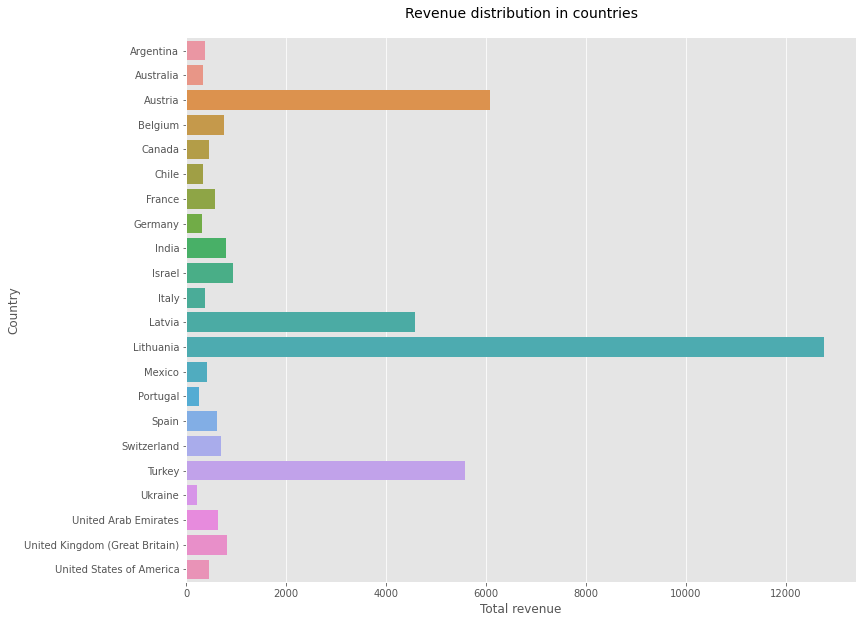

In [132]:
plt.figure(figsize = (12, 10))
sns.barplot(data = users_info \
                   .groupby('country', as_index = False) \
                   .agg({'total_revenue': 'mean'}) \
                    .query("total_revenue > 0"),
           y = 'country', x = 'total_revenue')
plt.xlabel("Total revenue", size=12)
plt.ylabel("Country", size=12)
plt.title('Revenue distribution in countries', pad = 20, size = 14)
sns.despine()

Записи о пользователях из стран с наибольшим значением дохода с total_revenue > 0

In [133]:
users_info.query("country == ['Lithuania', 'Latvia', 'Austria', 'Turkey'] and total_revenue > 0")

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,group,visits,total_revenue,age_group,visits_group
761,891508155,34,101,1.0,Latvia,"1,2,3,4,5,6,7,8,9,10,11,12,13",1,20,32,226,1.0,1.0,test,13,9165.0,2,3
950,892434141,21,387,64.0,Turkey,"1,2,3,20",1,18,24,49,1.0,0.0,test,4,9165.0,1,2
5182,891383310,22,1000,0.0,Turkey,1,1,19,83,4,1.0,1.0,control,1,63037.0,1,1
5294,891693753,24,311,50.0,Turkey,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",1,18,40,478,1.0,1.0,control,16,13026.0,1,3
8450,892344951,20,232,0.0,Turkey,"1,2,3,4,5,6,7",1,17,23,73,1.0,1.0,control,7,3614.0,1,3
9209,891494307,24,350,18.0,Turkey,"1,2,3,4,5,6,7,8,9,10,11,12,13",1,21,76,97,1.0,1.0,control,13,11700.0,1,3
11956,891672225,38,163,11.0,Austria,"1,2,8,9,10,11,12,13,15,16",1,35,41,49,1.0,1.0,control,10,12168.0,3,3
12474,891791565,42,103,0.0,Lithuania,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18",1,19,39,58,1.0,1.0,control,18,12766.0,3,3


Еще раз проверяем гипотезу о влиянии номинативных переменных (группы, к которой принадлежит пользователь и страны) на величину дохода total revenue без стран, которые создают выбросы.  
**H0** - доход с пользователя не зависит от страны и группы, к которой принадлежит пользователь, а также от совокупности этих факторов.  
**Результат** - величина метрики total_revenue не зависит от страны пользователя, взаимодействия факторов не оказывает значимое влияние на величину дохода.

In [134]:
formula = 'total_revenue ~ group + country + group:country'
model = ols(formula, users_info.query("country != ['Lithuania', 'Latvia', 'Austria', 'Turkey']")).fit()
aov_table = anova_lm(model, typ=2)
aov_table

/opt/tljh/user/lib/python3.7/site-packages/statsmodels/base/model.py:1865: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/opt/tljh/user/lib/python3.7/site-packages/statsmodels/base/model.py:1881: RuntimeWarning: invalid value encountered in true_divide
  F /= J
/opt/tljh/user/lib/python3.7/site-packages/statsmodels/base/model.py:1865: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 67, but rank is 42
  'rank is %d' % (J, J_), ValueWarning)
/opt/tljh/user/lib/python3.7/site-packages/statsmodels/base/model.py:1865: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 67, but rank is 48
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
group,NaN,1.0,NaN,NaN
country,4.545955e+08,67.0,0.563407,0.989879
group:country,2.361626e+08,67.0,0.292690,1.000000
Residual,1.539555e+11,12784.0,NaN,NaN


### Множественный ANOVA по метрике total_revenue для групп по количеству посещений:

**H0** - доход с пользователя не зависит от группы, к которой принадлежит пользователь, и группы по количеству посещений, а также от совокупности этих факторов.  
**Результат** - количество посещений приложения оказывает значимое влияние на величину total revenue, но группа и взаимодействие факторов значимого влияния не оказывают.

In [135]:
formula = 'total_revenue ~ group + visits_group + group:visits_group'
model = ols(formula, users_info).fit()
aov_table = anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
group,1.353312e+07,1.0,1.113118,2.914248e-01
visits_group,2.109480e+09,1.0,173.507777,2.274913e-39
group:visits_group,3.020099e+07,1.0,2.484075,1.150284e-01
Residual,1.569213e+11,12907.0,NaN,NaN


Визуализируем данные

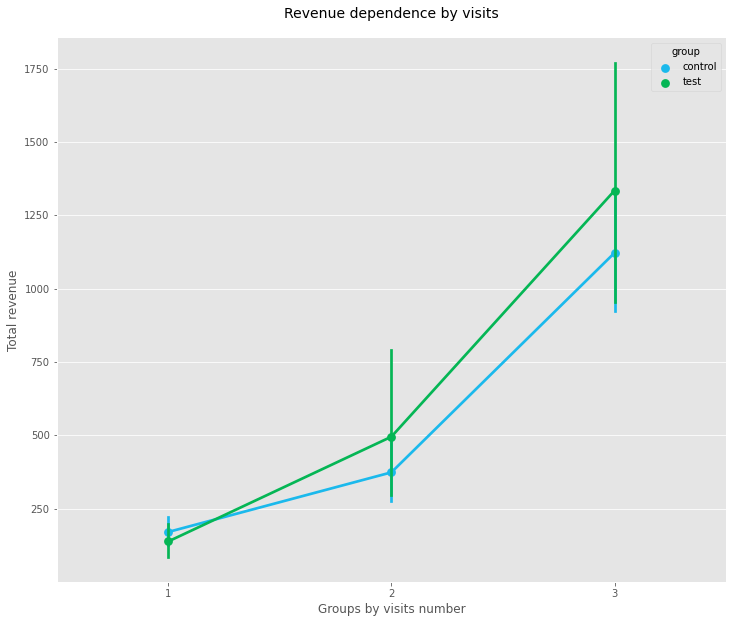

In [136]:
plt.figure(figsize = (12, 10))
sns.pointplot(data =users_info.sort_values('group'), 
              x = 'visits_group', 
              y ='total_revenue', 
              hue = 'group', 
              palette = group_palette)

plt.xlabel("Groups by visits number", size=12)
plt.ylabel("Total revenue", size=12)
plt.title('Revenue dependence by visits', pad = 20, size = 14)
sns.despine()

Попарные сравнения total revenue для групп по количеству посещений   
**H0** - ни одно из средних значений в выборках не отличается от других  
**Результат** - среднее хотя бы в одной группе значимо отличается от других.   

Различия в средних выборочных объясняются также и простой логикой: как правило, чем чаще пользователь пользуется приложением, тем чаще он совершает в нем покупки. В нашем случае пользователи, которые заходили в приложение не менее семи раз, в среднем тратили более 1000.

In [137]:
pg.pairwise_ttests(data = users_info, dv = 'total_revenue', between = 'visits_group')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,visits_group,1,2,False,True,-4.357197,4468.001294,two-sided,1.346947e-05,307.319,-0.109037
1,visits_group,1,3,False,True,-10.196419,3490.488679,two-sided,4.459765e-24,6.347e+20,-0.290743
2,visits_group,2,3,False,True,-6.829019,5114.345302,two-sided,9.545435e-12,3.218e+08,-0.169669


Проверим гипотезу о зависимости соотношения пользователей, формивших и не оформивших подписку, от количества визитов.

**H0** - количество пользователей, оформивших и не оформивших подписку не зависит от того, насколько часто пользователь посещал приложение 
**Результат** - отвергаем H0, значимые различия есть.

In [138]:
pd.crosstab(users_info.visits_group, users_info.is_premium)

is_premium,0.0,1.0
visits_group,,
1,5987,115
2,3411,158
3,2974,266


In [139]:
stats.chi2_contingency(pd.crosstab(users_info.visits_group, users_info.is_premium))

(212.43731827527333,
 7.410072572231754e-47,
 2,
 array([[5847.25768724,  254.74231276],
        [3420.00371776,  148.99628224],
        [3104.738595  ,  135.261405  ]]))

### Множественный ANOVA по метрике total_revenue для групп по возрасту:

**H0** - доход с пользователя не зависит от группы, к которой принадлежит пользователь, и группы по возрасту, а также от совокупности этих факторов.
**Результат** - ни возраст, ни взаимодействие факторов возраста и группы пользователя значимо не влияют на величину total_revenue

In [140]:
formula = 'total_revenue ~ group + age_group + group:age_group'
model = ols(formula, users_info).fit()
aov_table = anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
group,1.708329e+07,1.0,1.386419,0.239032
age_group,5.433057e+06,1.0,0.440928,0.506687
group:age_group,1.701778e+07,1.0,1.381103,0.239935
Residual,1.590385e+11,12907.0,NaN,NaN


Среднее значение total revenue для групп по возрасту

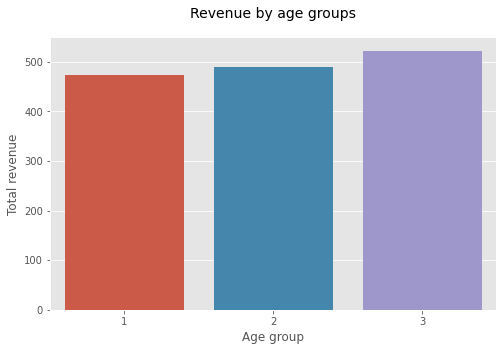

In [141]:
plt.figure(figsize = (8, 5))
sns.barplot(data = users_info \
                   .groupby('age_group', as_index = False) \
                   .agg({'total_revenue': 'mean'}).astype('int'),
           y = 'total_revenue', x = 'age_group')
plt.xlabel("Age group", size=12)
plt.ylabel("Total revenue", size=12)
plt.title('Revenue by age groups', pad = 20, size = 14)
sns.despine()

Проверим гипотезу о зависимости соотношения пользователей, формивших и не оформивших подписку, от возраста пользователя.

**H0** - количество пользователей, оформивших и не оформивших подписку не зависит от возраста пользователя.  
**Результат** - принимаем H0, значимых различий нет.

In [142]:
pd.crosstab(users_info.age_group, users_info.is_premium)

is_premium,0.0,1.0
age_group,,
1,5971,260
2,3101,135
3,3300,144


In [143]:
stats.chi2_contingency(pd.crosstab(users_info.age_group, users_info.is_premium))

(0.000492453507609744,
 0.9997538035575144,
 2,
 array([[5970.87227945,  260.12772055],
        [3100.90558439,  135.09441561],
        [3300.22213616,  143.77786384]]))

## Вывод:
Можно сделать вывод, что эксперимент не был успешен. После изменения стоимости премиум подписки ARPU статистически значимо не изменился. 

Увеличение стоимости премиум подписки не вызвало уменьшение частоты ее оформления, однако retention имеет довольно низкие значения в обоих группах.  
Большая часть пользователей оплачивали подписку 1 раз, а поскольку оплата подписки происходит ежемесячно, можно сделать вывод, что наши пользователи не очень заинтересованы в продлении подписки. Однако для корректного вывода по метрике retention rate стоит проанализировать больший временной промежуток.  

О неуспешности эксперимента также свидетельствуют различия в конверсии в оформление подписки между группами. В контрольной группе значение конверсии больше. Соотношение пользователей, сконвертировавшихся в целевое действие, значимо отличается в группах.

ARPU по подписке и по категориям трат, не связанным с подпиской также не имеет стат значимых различий между группами.

При сравнении групп значимое влияние на размер дохода total revenue от пользователя показал только фактор количества визитов. Что может объясняться простой логикой - чем чаще пользователь посещает приложение, тем больше он, скорее всего, платит за различные продукты.

Значимых различий в доходе total revenue между пользователями из разных стран и разных возрастов не наблюдается. 

Наличие премиум подписки, как правило, зависит от того, была ли у пользователя подписка ранее, и того, как часто пользователь посещает приложение, при этом возраст не оказывает значимого влияния на соотношение пользователей с премиум подпиской и без нее.

Можно сделать вывод, что увеличение стоимости премиум подписки привело к уменьшению конверсии, и за счет этого ARPU в группах значимо не различается.